In [2]:
import tensorflow as tf
import pandas as pd
import numpy as np
import keras

In [17]:
path = '/home/murilo/workspace/tcc/tcc/python_model/src'

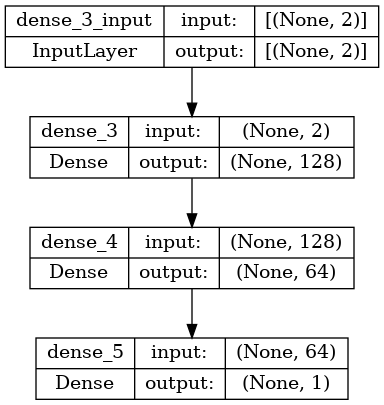

In [18]:
model_py = tf.keras.models.load_model(f"{path}/python_model.h5")
keras.utils.plot_model(model_py, "model.png", show_shapes=True)

## TFLite - Quantização de Faixa Dinâmica 

A quantização de faixa dinâmica é a mais simples e rápida, quantizando somente os pesos do modelo de ponto flutuante para inteiros de 8 bits.

In [19]:
converter = tf.lite.TFLiteConverter.from_keras_model(model_py)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quant_model = converter.convert()

with open('model_dynamic_range_quantized.tflite', 'wb') as f:
    f.write(tflite_quant_model)

INFO:tensorflow:Assets written to: /tmp/tmpudfuq607/assets


INFO:tensorflow:Assets written to: /tmp/tmpudfuq607/assets
2024-05-11 14:11:45.926637: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2024-05-11 14:11:45.926668: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2024-05-11 14:11:45.926854: I tensorflow/cc/saved_model/reader.cc:43] Reading SavedModel from: /tmp/tmpudfuq607
2024-05-11 14:11:45.927972: I tensorflow/cc/saved_model/reader.cc:81] Reading meta graph with tags { serve }
2024-05-11 14:11:45.928004: I tensorflow/cc/saved_model/reader.cc:122] Reading SavedModel debug info (if present) from: /tmp/tmpudfuq607
2024-05-11 14:11:45.931168: I tensorflow/cc/saved_model/loader.cc:228] Restoring SavedModel bundle.
2024-05-11 14:11:45.965263: I tensorflow/cc/saved_model/loader.cc:212] Running initialization op on SavedModel bundle at path: /tmp/tmpudfuq607
2024-05-11 14:11:45.975303: I tensorflow/cc/saved_model/loader.cc:301] SavedModel

## Quantização Float16

Esta configuração converte todos os pesos e ativações para float16, que é útil para dispositivos com suporte nativo a esse formato.

In [20]:
converter = tf.lite.TFLiteConverter.from_keras_model(model_py)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.target_spec.supported_types = [tf.float16]
tflite_model_float16 = converter.convert()

with open('model_float16_quantized.tflite', 'wb') as f:
    f.write(tflite_model_float16)

INFO:tensorflow:Assets written to: /tmp/tmppvbv2rcx/assets


INFO:tensorflow:Assets written to: /tmp/tmppvbv2rcx/assets
2024-05-11 14:11:46.758279: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2024-05-11 14:11:46.758308: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2024-05-11 14:11:46.758422: I tensorflow/cc/saved_model/reader.cc:43] Reading SavedModel from: /tmp/tmppvbv2rcx
2024-05-11 14:11:46.759259: I tensorflow/cc/saved_model/reader.cc:81] Reading meta graph with tags { serve }
2024-05-11 14:11:46.759285: I tensorflow/cc/saved_model/reader.cc:122] Reading SavedModel debug info (if present) from: /tmp/tmppvbv2rcx
2024-05-11 14:11:46.763443: I tensorflow/cc/saved_model/loader.cc:228] Restoring SavedModel bundle.
2024-05-11 14:11:46.794602: I tensorflow/cc/saved_model/loader.cc:212] Running initialization op on SavedModel bundle at path: /tmp/tmppvbv2rcx
2024-05-11 14:11:46.806463: I tensorflow/cc/saved_model/loader.cc:301] SavedModel

## Quantização Inteira Completa

Esta abordagem quantiza todos os pesos e ativações para inteiros de 8 bits e requer um conjunto de dados representativo para calibrar a quantização.

In [21]:
path = '/home/murilo/workspace/tcc/tcc/python_model/database/x_train.csv'
x_train = pd.read_csv(path)

def representative_dataset_generator():
    for value in x_train.values:
        yield [np.array(value, dtype=np.float32, ndmin=2)]

In [22]:
converter = tf.lite.TFLiteConverter.from_keras_model(model_py)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_dataset_generator
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.inference_input_type = tf.int8
converter.inference_output_type = tf.int8

tflite_model = converter.convert()

with open('model_full_integer_quantized.tflite', 'wb') as f:
    f.write(tflite_model)

INFO:tensorflow:Assets written to: /tmp/tmp1oz_2w_1/assets


INFO:tensorflow:Assets written to: /tmp/tmp1oz_2w_1/assets
/home/murilo/workspace/tcc/tcc/python_model/.env/lib/python3.10/site-packages/tensorflow/lite/python/convert.py:766: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn("Statistics for quantized inputs were expected, but not "
2024-05-11 14:11:47.383724: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2024-05-11 14:11:47.383759: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2024-05-11 14:11:47.383900: I tensorflow/cc/saved_model/reader.cc:43] Reading SavedModel from: /tmp/tmp1oz_2w_1
2024-05-11 14:11:47.384936: I tensorflow/cc/saved_model/reader.cc:81] Reading meta graph with tags { serve }
2024-05-11 14:11:47.384985: I tensorflow/cc/saved_model/reader.cc:122] Reading SavedModel debug info (if present) from: /tmp/tmp1oz_2w_1
2024-05-11 14:11:47.389377: I tensor

## Quantização Somente Inteiro (Weight-only Quantization)

Quantiza somente os pesos para inteiros de 8 bits.

In [23]:
converter = tf.lite.TFLiteConverter.from_keras_model(model_py)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS]
tflite_model_weights_only = converter.convert()

with open('model_weights_only_quantized.tflite', 'wb') as f:
    f.write(tflite_model_weights_only)

INFO:tensorflow:Assets written to: /tmp/tmp3ke7k1af/assets


INFO:tensorflow:Assets written to: /tmp/tmp3ke7k1af/assets
2024-05-11 14:11:48.001223: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2024-05-11 14:11:48.001252: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2024-05-11 14:11:48.001367: I tensorflow/cc/saved_model/reader.cc:43] Reading SavedModel from: /tmp/tmp3ke7k1af
2024-05-11 14:11:48.002074: I tensorflow/cc/saved_model/reader.cc:81] Reading meta graph with tags { serve }
2024-05-11 14:11:48.002090: I tensorflow/cc/saved_model/reader.cc:122] Reading SavedModel debug info (if present) from: /tmp/tmp3ke7k1af
2024-05-11 14:11:48.004541: I tensorflow/cc/saved_model/loader.cc:228] Restoring SavedModel bundle.
2024-05-11 14:11:48.035915: I tensorflow/cc/saved_model/loader.cc:212] Running initialization op on SavedModel bundle at path: /tmp/tmp3ke7k1af
2024-05-11 14:11:48.045315: I tensorflow/cc/saved_model/loader.cc:301] SavedModel